# Prediction Modelling for Hotel Ratings from Reviews, Reviewer Nationality and Hotel Location



## Business Problem

#### Goals
- Determine a relationship between reviews and the rating a reviewer gives.
- Reviewer Nationality can affect ratings

#### Other Impacts on Review Ratings
- Stay Duration
- Reviewer Nationality
- Location of the Hotel
- Number of Reviews
- Tags associated with the Trip

#### Why?
- This could allow the development of review apps and websites that could allow pre-filled rating based on a review.
- Allow improvements of Hotels based on reviews


## Risks and Limitations
- Assumption that Reviews are Honest. 
- Hotel is treated as constant.
- Low Score is solely due factors discussed in written reivew.
- Each review is treated as seperate.
- External Factors are ignored

### Data Access
Data was obtained from [Kaggle](https://www.kaggle.com/jiashenliu/515k-hotel-reviews-data-in-europe)

## The Review Data

#### Acknowledgements
The data was scraped from Booking.com by [Jason Liu](https://www.kaggle.com/jiashenliu)

#### Data Context
- 515,000 customer reviews
- 1492 luxury hotels within Europe

#### Data Content
- **Hotel_Address**: Address of hotel.
- **Review_Date:** Date when reviewer posted the corresponding review.
- **Average_Score:** Average Score of the hotel, calculated based on the latest comment in the last year.
- **Hotel_Name:** Name of Hotel
- **Reviewer_Nationality:** Nationality of Reviewer
- **Negative_Review:** Negative Review the reviewer gave to the hotel. If the reviewer does not give the negative review, then it should be: 'No Negative'
- **Review_Total_Negative_Word_Counts:** Total number of words in the negative review.
- **Positive_Review:** Positive Review the reviewer gave to the hotel. If the reviewer does not give the negative review, then it should be: 'No Positive'

- **Review_Total_Positive_Word_Counts:** Total number of words in the positive review.
- **Reviewer_Score:** Score the reviewer has given to the hotel, based on his/her experience
- **Total_Number_of_Reviews_Reviewer_Has_Given:** Number of Reviews the reviewers has given in the past.
- **Total_Number_of_Reviews:** Total number of valid reviews the hotel has.
- **Tags:** Tags reviewer gave the hotel.
- **days_since_review:** Duration between the review date and scrape date.
- **Additional_Number_of_Scoring:** There are also some guests who just made a scoring on the service rather than a review. This number indicates how many valid scores without review in there.
- **lat:** Latitude of the hotel
- **lng:** longtitude of the hotel

In [29]:
# Script Name: EDA of Hotel Reviews Data
# Author: Rahul Kumar
# Date: 2-Jan-20
# Description: The purpose is to clean up data in preperation for Model running

import pandas as pd
import numpy as np
from math import sqrt
import seaborn as sns
import scipy as sp
from textblob import TextBlob, Word
from nltk.stem.snowball import SnowballStemmer

#this supposedly extracts country from a text line
import pycountry

from IPython.display import HTML, display

import matplotlib.pyplot as plt
%matplotlib inline

# This actually sets the pandas display to show all rows and columns 
# when you are showing a dataframe, without skipping the center
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
hotels = pd.read_csv('../Hotel_Reviews.csv')
hotels_og = hotels


In [30]:
import random

def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'Toggle show/hide'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)

### Preview of the Data
- Note the Review Score is the label to be predicted

In [31]:
hotels.head(4)

,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Tags,days_since_review,lat,lng
0,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Russia,I am so angry that i made this post available...,397,1403,Only the park outside of the hotel was beauti...,11,7,2.9,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968
1,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Ireland,No Negative,0,1403,No real complaints the hotel was great great ...,105,7,7.5,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968
2,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/31/2017,7.7,Hotel Arena,Australia,Rooms are nice but for elderly a bit difficul...,42,1403,Location was good and staff were ok It is cut...,21,9,7.1,"[' Leisure trip ', ' Family with young childre...",3 days,52.360576,4.915968
3,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/31/2017,7.7,Hotel Arena,United Kingdom,My room was dirty and I was afraid to walk ba...,210,1403,Great location in nice surroundings the bar a...,26,1,3.8,"[' Leisure trip ', ' Solo traveler ', ' Duplex...",3 days,52.360576,4.915968


## Explatory Data Analysis
The Data was in a workable state and not much primary cleaning had to be done.

- Basic Text Cleaning
- Dropped Null Values
- Basic Text and Dataframe Manipulation
- Some relationships were observed

In [32]:
hotels.dtypes

Hotel_Address                                  object
Additional_Number_of_Scoring                    int64
Review_Date                                    object
Average_Score                                 float64
Hotel_Name                                     object
Reviewer_Nationality                           object
Negative_Review                                object
Review_Total_Negative_Word_Counts               int64
Total_Number_of_Reviews                         int64
Positive_Review                                object
Review_Total_Positive_Word_Counts               int64
Total_Number_of_Reviews_Reviewer_Has_Given      int64
Reviewer_Score                                float64
Tags                                           object
days_since_review                              object
lat                                           float64
lng                                           float64
dtype: object

#### Data Types
- Object
    - Text Strings
    - List
- Integer
    - Only Additional Number of Scoring
- Float
    - Scores
    - Latitude, Longitude

In [33]:
hotels.isnull().sum().to_frame()

,0
Hotel_Address,0
Additional_Number_of_Scoring,0
Review_Date,0
Average_Score,0
Hotel_Name,0
Reviewer_Nationality,0
Negative_Review,0
Review_Total_Negative_Word_Counts,0
Total_Number_of_Reviews,0
Positive_Review,0


In [34]:
hotels.describe()

,Additional_Number_of_Scoring,Average_Score,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,lat,lng
count,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,512470.000000,512470.000000
mean,498.081836,8.397487,18.539450,2743.743944,17.776458,7.166001,8.395077,49.442439,2.823803
std,500.538467,0.548048,29.690831,2317.464868,21.804185,11.040228,1.637856,3.466325,4.579425
min,1.000000,5.200000,0.000000,43.000000,0.000000,1.000000,2.500000,41.328376,-0.369758
25%,169.000000,8.100000,2.000000,1161.000000,5.000000,1.000000,7.500000,48.214662,-0.143372
50%,341.000000,8.400000,9.000000,2134.000000,11.000000,3.000000,8.800000,51.499981,0.010607
75%,660.000000,8.800000,23.000000,3613.000000,22.000000,8.000000,9.600000,51.516288,4.834443
max,2682.000000,9.800000,408.000000,16670.000000,395.000000,355.000000,10.000000,52.400181,16.429233


In [35]:
hotels.groupby('Hotel_Name').mean().head()

,Additional_Number_of_Scoring,Average_Score,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,lat,lng
Hotel_Name,,,,,,,,,
11 Cadogan Gardens,101.0,8.7,15.528302,393.0,19.974843,7.226415,8.845283,51.493616,-0.159235
1K Hotel,69.0,7.7,24.932432,663.0,15.601351,9.141892,7.861486,48.863932,2.365874
25hours Hotel beim MuseumsQuartier,391.0,8.8,16.161103,4324.0,21.911466,8.722787,8.983309,48.206474,16.354630
41,66.0,9.6,8.883495,244.0,25.300971,6.009709,9.711650,51.498147,-0.143649
45 Park Lane Dorchester Collection,27.0,9.4,6.750000,68.0,11.535714,7.214286,9.603571,51.506371,-0.151536


In [36]:
# Value Count for the Hotel Names. This would give an idea, perhaps to see if 
# a place has less than a certain number of reviews we can ignore it perhaps
Hotel_Names_Count = hotels.Hotel_Name.value_counts()
Hotel_Names_Count.head()

Britannia International Hotel Canary Wharf           4789
Strand Palace Hotel                                  4256
Park Plaza Westminster Bridge London                 4169
Copthorne Tara Hotel London Kensington               3578
DoubleTree by Hilton Hotel London Tower of London    3212
Name: Hotel_Name, dtype: int64

In [37]:
len(Hotel_Names_Count)

1492

In [38]:
hotels.shape

(515738, 17)

### Trimming the Data
- Large Data set
    - 515738 Entries
    - 17 Features Columns

- Exclude Hotels that have entries < 150 Reviews
    - 466868 Entries
    - 17 Feature Columns

### Data Visualisation
- Relationships between potential predicition labels and the predicted review score
    - Total Review Count
    - Word Count
    - Negative and Positive Review Word Count

This helps towards Feature Selection
    - Hint: Only the Number of Reviews given by Reviewer ends up being used.

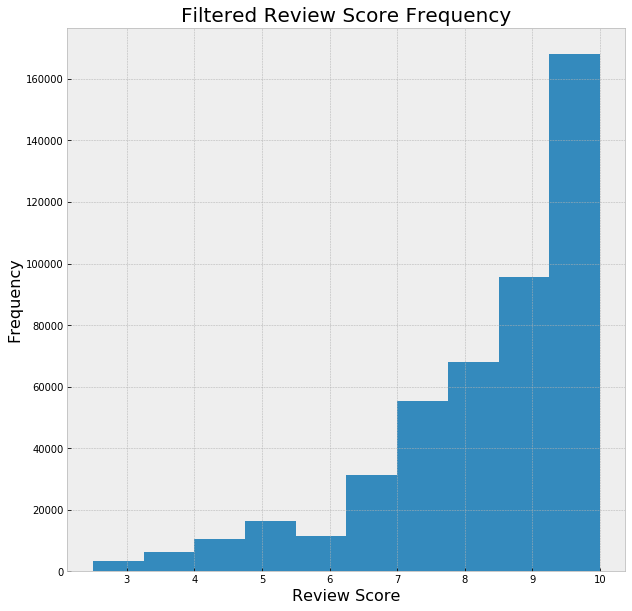

In [39]:
# There is a lot of Data here, perhaps a little too much. Especially for the time scope I have. So I will be removing Hotels
# Value Counts Less than < 149. This will probably affect the prediction, but I feel in the grand scheme of the actualy data,
# I don't think it will bring too many changes.

# I found this online that helps clear a dataframe based on minimum frequency occurance
def filter_by_freq(df: pd.DataFrame, column: str, min_freq: int) -> pd.DataFrame:
    """Filters the DataFrame based on the value frequency in the specified column.

    :param df: DataFrame to be filtered.
    :param column: Column name that should be frequency filtered.
    :param min_freq: Minimal value frequency for the row to be accepted.
    :return: Frequency filtered DataFrame.
    """
    # Frequencies of each value in the column.
    freq = df[column].value_counts()
    # Select frequent values. Value is in the index.
    frequent_values = freq[freq >= min_freq].index
    # Return only rows with value frequency above threshold.
    return df[df[column].isin(frequent_values)]

# Overwriting it.

hotels = filter_by_freq(hotels,'Hotel_Name', 150)

#fig, (ax1, ax2) = plt.subplots(1, 2)

#ax1.plot(hotels_og.Reviewer_Score, y)
#ax2.plot(x, -y)

#plt.style.use('ggplot')
#plt.figure(figsize=(10,10))
#hotels_og.Reviewer_Score.ax1.plot(kind='hist', bins=10)
#plt.xlabel('Review Score',fontsize=16)
#plt.ylabel('Frequency',fontsize=16)
#plt.title('Review Score Frequency',fontsize=20)
#plt.savefig('images/review_score_freq.png')

plt.style.use('bmh')
plt.figure(figsize=(10,10))
hotels.Reviewer_Score.plot(kind='hist', bins=10)
plt.xlabel('Review Score',fontsize=16)
plt.ylabel('Frequency',fontsize=16)
plt.title('Filtered Review Score Frequency',fontsize=20)
plt.savefig('images/trim_review_score_freq.png')



![Review_Score](images/trim_review_score_freq.png)

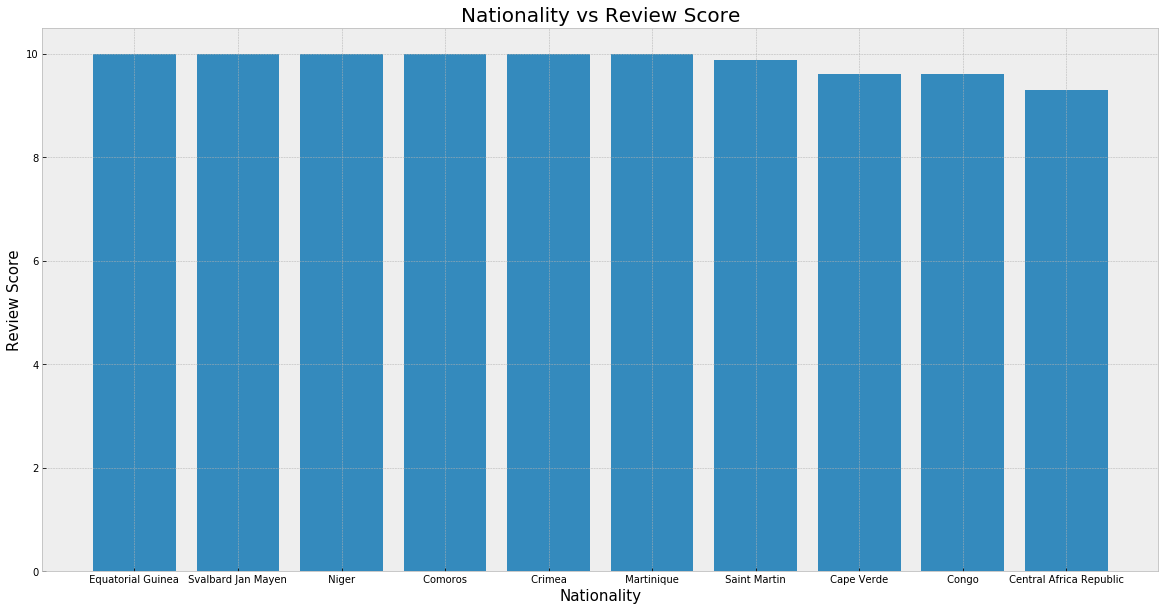

In [40]:
review_nation = hotels[['Reviewer_Nationality', 'Reviewer_Score']]
grouped = review_nation.groupby('Reviewer_Nationality').mean().reset_index()
test = grouped.sort_values('Reviewer_Score', ascending=False).head(20)

plt.figure(figsize=(20,10))

#Value Counts for Reviewer Nationality, as if the nationality is rare, we won't really get any meaningful information from it
plt.bar(test.Reviewer_Nationality.head(10), test.Reviewer_Score.head(10))
plt.xlabel('Nationality',fontsize=15)
plt.ylabel('Review Score',fontsize=15)
plt.title('Nationality vs Review Score',fontsize=20)
plt.savefig('images/top_10_scoring_nationality.png')


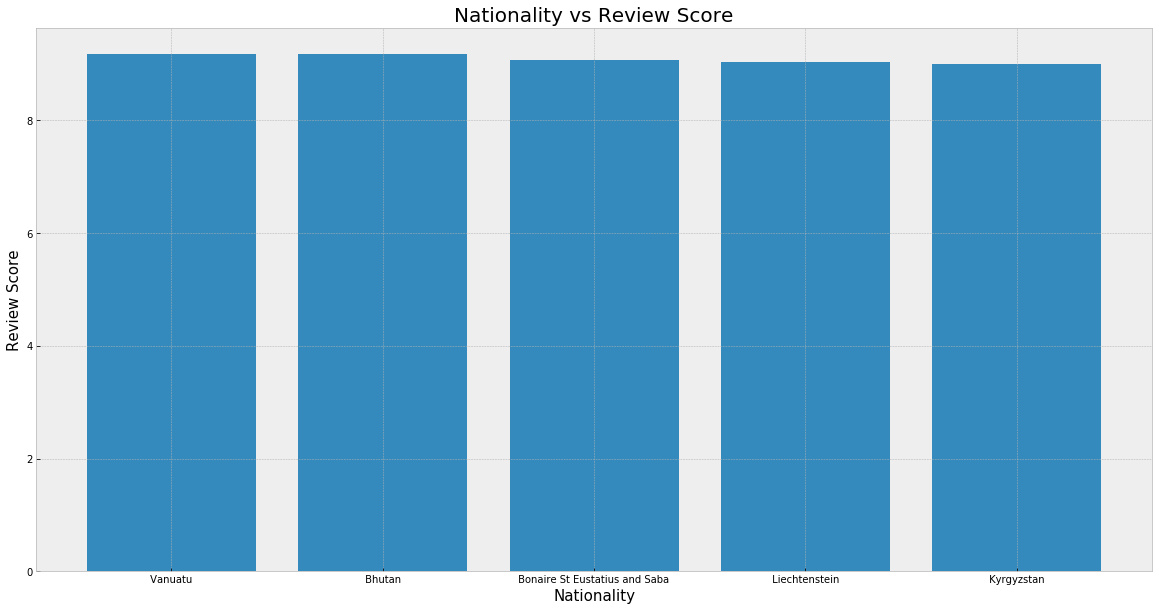

In [41]:
plt.figure(figsize=(20,10))

#Value Counts for Reviewer Nationality, as if the nationality is rare, we won't really get any meaningful information from it
plt.bar(test.Reviewer_Nationality.tail(5), test.Reviewer_Score.tail(5))
plt.xlabel('Nationality',fontsize=15)
plt.ylabel('Review Score',fontsize=15)
plt.title('Nationality vs Review Score',fontsize=20)
plt.savefig('images/bottom_5_scoring_nationality.png')

![Top_10](images/top_10_scoring_nationality.png)

![Bottom_5](images/bottom_5_scoring_nationality.png)

### Extracting Country
- Using Library called [PyCountry](https://pypi.org/project/pycountry/)
- We can Extract the Country from a string.
- Shown how it was done below

In [42]:
text = "140 Gloucester Road Kensington and Chelsea London SW7 4QH United Kingdom"
for country in pycountry.countries:
    if country.name in text:
        print(country.name)

United Kingdom


- No need for Lat and Lon

In [43]:
# Have a quick function that returns the Country
def country_txt(text):
    for country in pycountry.countries:
        if country.name in text:
            return country.name
        
hotels['Country'] = hotels['Hotel_Address'].apply(country_txt)
hotels.head(5)

C:\Users\rahul\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Tags,days_since_review,lat,lng,Country
0,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Russia,I am so angry that i made this post available...,397,1403,Only the park outside of the hotel was beauti...,11,7,2.9,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968,Netherlands
1,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Ireland,No Negative,0,1403,No real complaints the hotel was great great ...,105,7,7.5,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968,Netherlands
2,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/31/2017,7.7,Hotel Arena,Australia,Rooms are nice but for elderly a bit difficul...,42,1403,Location was good and staff were ok It is cut...,21,9,7.1,"[' Leisure trip ', ' Family with young childre...",3 days,52.360576,4.915968,Netherlands
3,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/31/2017,7.7,Hotel Arena,United Kingdom,My room was dirty and I was afraid to walk ba...,210,1403,Great location in nice surroundings the bar a...,26,1,3.8,"[' Leisure trip ', ' Solo traveler ', ' Duplex...",3 days,52.360576,4.915968,Netherlands
4,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/24/2017,7.7,Hotel Arena,New Zealand,You When I booked with your company on line y...,140,1403,Amazing location and building Romantic setting,8,3,6.7,"[' Leisure trip ', ' Couple ', ' Suite ', ' St...",10 days,52.360576,4.915968,Netherlands


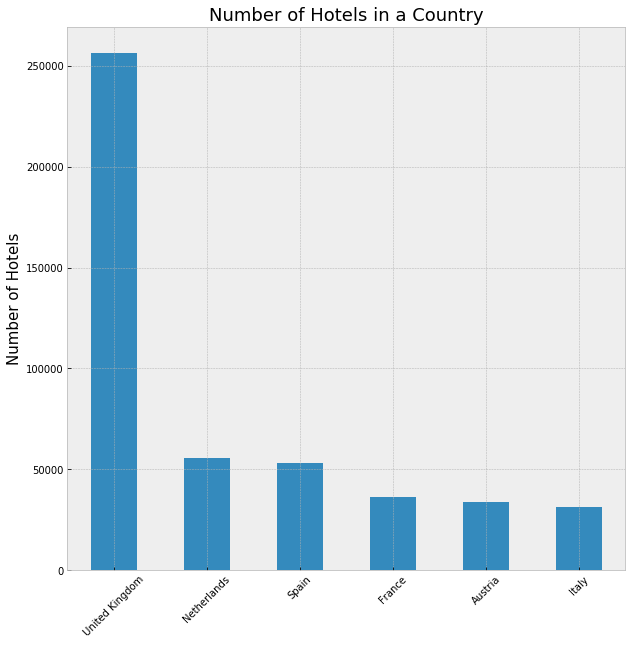

In [44]:
plt.figure(figsize=(10,10))

#Value Counts for Reviewer Nationality, as if the nationality is rare, we won't really get any meaningful information from it
hotels.Country.value_counts().plot.bar()

plt.ylabel('Number of Hotels',fontsize=15)
plt.title('Number of Hotels in a Country',fontsize=18)
plt.xticks(rotation=45)
plt.savefig('images/Hotels_Country.png')

![Hotels_Country](images/Hotels_Country.png)

In [45]:
#pp = sns.pairplot(hotels)
#pp.savefig("images/PairPlot.png")

### Data Relationships
- Created a Seaborn Pair Plot to visualise the relationships
- Too much data to visually identify a decent connections
- Heatmap was much more clearer

![Pair_Plot](images/PairPlot.png)

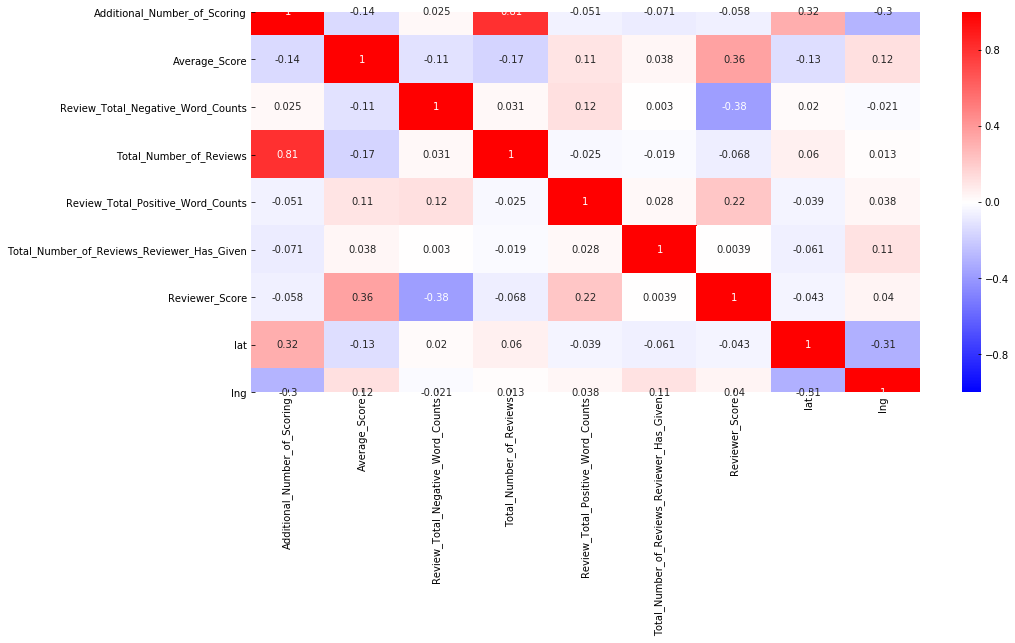

In [46]:
hotels_correlations = hotels.corr()
hotels_correlations
plt.figure(figsize=(15,7))
hm = sns.heatmap(hotels_correlations, vmin = -1, vmax = 1, cmap = 'bwr', annot=True);
figure = hm.get_figure()    
figure.savefig('images/heatmap.png', dpi=400)

#### Heat Map
![Heat_Map](images/heatmap.png)

### Feature Selection and Generation
- Longest process
- Still can be done
- Tags has most information
- Extract Duration of stay
- Look at important Tags


### Extraction of Stay Duration
- The Tags are a string
- Using the find function look for Stay and Nights within the string 
- Slice the string between the words and extract integer
- "[' Leisure trip ', ' Couple ', ' Duplex Double Room ', ' Stayed 6 nights ']" -> 6
- If the tag doesn't exist - None is returned

In [50]:
def backtostring(lst):
    standin = ""
    string = standin.join(lst)
    return string
hotels['Tags_String'] = hotels.Tags.apply(backtostring)
def stayed_night(string):
    x = string.find('Stayed')
    y = string.find('nights')
    string = string[x:y+6]
    # Found this online, creates a list of integers in a string.
    res = [int(i) for i in string.split() if i.isdigit()] 
    if len(res) == 0:
        stayed = None
    else:
        stayed = res[0]
        
    return stayed

hotels['Trip_Duration'] = hotels.Tags_String.apply(stayed_night)
hotels.head()

C:\Users\rahul\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\rahul\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Tags,days_since_review,lat,lng,Country,Tags_list_length,Tag_1,Tag_2,Tag_3,Tag_4,Tag_5,Tag_6,Tags_String,Trip_Duration
0,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Russia,I am so angry that i made this post available...,397,1403,Only the park outside of the hotel was beauti...,11,7,2.9,"[[' Leisure trip ', ' Couple ', ' Duplex Dou...",0 days,52.360576,4.915968,Netherlands,4,Leisure trip,Couple,Duplex Double Room,Stayed 6 nights,None,None,[' Leisure trip ' ' Couple ' ' Duplex Double R...,6.0
1,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Ireland,No Negative,0,1403,No real complaints the hotel was great great ...,105,7,7.5,"[[' Leisure trip ', ' Couple ', ' Duplex Dou...",0 days,52.360576,4.915968,Netherlands,4,Leisure trip,Couple,Duplex Double Room,Stayed 4 nights,None,None,[' Leisure trip ' ' Couple ' ' Duplex Double R...,4.0
2,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/31/2017,7.7,Hotel Arena,Australia,Rooms are nice but for elderly a bit difficul...,42,1403,Location was good and staff were ok It is cut...,21,9,7.1,"[[' Leisure trip ', ' Family with young child...",3 days,52.360576,4.915968,Netherlands,5,Leisure trip,Family with young children,Duplex Double Room,Stayed 3 nights,Submitted from a mobile device,None,[' Leisure trip ' ' Family with young children...,3.0
3,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/31/2017,7.7,Hotel Arena,United Kingdom,My room was dirty and I was afraid to walk ba...,210,1403,Great location in nice surroundings the bar a...,26,1,3.8,"[[' Leisure trip ', ' Solo traveler ', ' Dup...",3 days,52.360576,4.915968,Netherlands,4,Leisure trip,Solo traveler,Duplex Double Room,Stayed 3 nights,None,None,[' Leisure trip ' ' Solo traveler ' ' Duplex D...,3.0
4,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/24/2017,7.7,Hotel Arena,New Zealand,You When I booked with your company on line y...,140,1403,Amazing location and building Romantic setting,8,3,6.7,"[[' Leisure trip ', ' Couple ', ' Suite ', ...",10 days,52.360576,4.915968,Netherlands,5,Leisure trip,Couple,Suite,Stayed 2 nights,Submitted from a mobile device,None,[' Leisure trip ' ' Couple ' ' Suite ' ' Staye...,2.0


In [51]:
hotels.head()

,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Tags,days_since_review,lat,lng,Country,Tags_list_length,Tag_1,Tag_2,Tag_3,Tag_4,Tag_5,Tag_6,Tags_String,Trip_Duration
0,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Russia,I am so angry that i made this post available...,397,1403,Only the park outside of the hotel was beauti...,11,7,2.9,"[[' Leisure trip ', ' Couple ', ' Duplex Dou...",0 days,52.360576,4.915968,Netherlands,4,Leisure trip,Couple,Duplex Double Room,Stayed 6 nights,None,None,[' Leisure trip ' ' Couple ' ' Duplex Double R...,6.0
1,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Ireland,No Negative,0,1403,No real complaints the hotel was great great ...,105,7,7.5,"[[' Leisure trip ', ' Couple ', ' Duplex Dou...",0 days,52.360576,4.915968,Netherlands,4,Leisure trip,Couple,Duplex Double Room,Stayed 4 nights,None,None,[' Leisure trip ' ' Couple ' ' Duplex Double R...,4.0
2,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/31/2017,7.7,Hotel Arena,Australia,Rooms are nice but for elderly a bit difficul...,42,1403,Location was good and staff were ok It is cut...,21,9,7.1,"[[' Leisure trip ', ' Family with young child...",3 days,52.360576,4.915968,Netherlands,5,Leisure trip,Family with young children,Duplex Double Room,Stayed 3 nights,Submitted from a mobile device,None,[' Leisure trip ' ' Family with young children...,3.0
3,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/31/2017,7.7,Hotel Arena,United Kingdom,My room was dirty and I was afraid to walk ba...,210,1403,Great location in nice surroundings the bar a...,26,1,3.8,"[[' Leisure trip ', ' Solo traveler ', ' Dup...",3 days,52.360576,4.915968,Netherlands,4,Leisure trip,Solo traveler,Duplex Double Room,Stayed 3 nights,None,None,[' Leisure trip ' ' Solo traveler ' ' Duplex D...,3.0
4,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/24/2017,7.7,Hotel Arena,New Zealand,You When I booked with your company on line y...,140,1403,Amazing location and building Romantic setting,8,3,6.7,"[[' Leisure trip ', ' Couple ', ' Suite ', ...",10 days,52.360576,4.915968,Netherlands,5,Leisure trip,Couple,Suite,Stayed 2 nights,Submitted from a mobile device,None,[' Leisure trip ' ' Couple ' ' Suite ' ' Staye...,2.0


### Seperation of Tags
- Convert the string to a list
- Calculate the largest number of Tags, which is 6
- Create Columns Named Tags_1 to Tags_6
- Using Values.tolist() Populate the columns with Tags
- Clean up Strings by removing symbols and odd spacings


In [47]:
# Was correct It is a string. So now the next step is to covert it into a list. Using the previous homework function I made.

def string_split(string):
    return list(string.split(","))

hotels['Tags'] = hotels.Tags.apply(string_split)
hotels['Tags_list_length'] = hotels.Tags.apply(lambda x: len(x))
hotels.head()
hotels[['Tag_1','Tag_2','Tag_3','Tag_4','Tag_5','Tag_6']] = pd.DataFrame(hotels.Tags.values.tolist(), index= hotels.index)
hotels.head(50)
def string_clean(word):
    if word is None:
        return None
    else:
        word = word.replace("\'", '') #This gets rid of all ', which might make some names weird. but this saves making a 
                                    # a seperate function. perhaps an If statement might work
        word = word.replace("[", '')
        word = word.replace("]", '')
        word = word
        if word[0] == " " and word[1] == " ":
            word = word[2:]
        elif word[0] == " ":
            word = word[1:]
        word = word[:-1] #Removes Space at the end :c
        return word

hotels['Tag_1'] = hotels.Tag_1.apply(string_clean)
hotels['Tag_2'] = hotels.Tag_2.apply(string_clean)
hotels['Tag_3'] = hotels.Tag_3.apply(string_clean)
hotels['Tag_4'] = hotels.Tag_4.apply(string_clean)
hotels['Tag_5'] = hotels.Tag_5.apply(string_clean)
hotels['Tag_6'] = hotels.Tag_6.apply(string_clean)

hotels.head(10)

C:\Users\rahul\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\rahul\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\rahul\Anaconda3\lib\site-packages\pandas\core\frame.py:3494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pyd

,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Tags,days_since_review,lat,lng,Country,Tags_list_length,Tag_1,Tag_2,Tag_3,Tag_4,Tag_5,Tag_6
0,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Russia,I am so angry that i made this post available...,397,1403,Only the park outside of the hotel was beauti...,11,7,2.9,"[[' Leisure trip ', ' Couple ', ' Duplex Dou...",0 days,52.360576,4.915968,Netherlands,4,Leisure trip,Couple,Duplex Double Room,Stayed 6 nights,None,None
1,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Ireland,No Negative,0,1403,No real complaints the hotel was great great ...,105,7,7.5,"[[' Leisure trip ', ' Couple ', ' Duplex Dou...",0 days,52.360576,4.915968,Netherlands,4,Leisure trip,Couple,Duplex Double Room,Stayed 4 nights,None,None
2,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/31/2017,7.7,Hotel Arena,Australia,Rooms are nice but for elderly a bit difficul...,42,1403,Location was good and staff were ok It is cut...,21,9,7.1,"[[' Leisure trip ', ' Family with young child...",3 days,52.360576,4.915968,Netherlands,5,Leisure trip,Family with young children,Duplex Double Room,Stayed 3 nights,Submitted from a mobile device,None
3,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/31/2017,7.7,Hotel Arena,United Kingdom,My room was dirty and I was afraid to walk ba...,210,1403,Great location in nice surroundings the bar a...,26,1,3.8,"[[' Leisure trip ', ' Solo traveler ', ' Dup...",3 days,52.360576,4.915968,Netherlands,4,Leisure trip,Solo traveler,Duplex Double Room,Stayed 3 nights,None,None
4,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/24/2017,7.7,Hotel Arena,New Zealand,You When I booked with your company on line y...,140,1403,Amazing location and building Romantic setting,8,3,6.7,"[[' Leisure trip ', ' Couple ', ' Suite ', ...",10 days,52.360576,4.915968,Netherlands,5,Leisure trip,Couple,Suite,Stayed 2 nights,Submitted from a mobile device,None
5,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/24/2017,7.7,Hotel Arena,Poland,Backyard of the hotel is total mess shouldn t...,17,1403,Good restaurant with modern design great chil...,20,1,6.7,"[[' Leisure trip ', ' Group ', ' Duplex Doub...",10 days,52.360576,4.915968,Netherlands,4,Leisure trip,Group,Duplex Double Room,Stayed 1 night,None,None
6,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/17/2017,7.7,Hotel Arena,United Kingdom,Cleaner did not change our sheet and duvet ev...,33,1403,The room is spacious and bright The hotel is ...,18,6,4.6,"[[' Leisure trip ', ' Group ', ' Duplex Twin...",17 days,52.360576,4.915968,Netherlands,5,Leisure trip,Group,Duplex Twin Room,Stayed 5 nights,Submitted from a mobile device,None
7,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/17/2017,7.7,Hotel Arena,United Kingdom,Apart from the price for the brekfast Everyth...,11,1403,Good location Set in a lovely park friendly s...,19,1,10.0,"[[' Leisure trip ', ' Couple ', ' Duplex Dou...",17 days,52.360576,4.915968,Netherlands,5,Leisure trip,Couple,Duplex Double Room,Stayed 2 nights,Submitted from a mobile device,None
8,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/9/2017,7.7,Hotel Arena,Belgium,Even though the pictures show very clean room...,34,1403,No Positive,0,3,6.5,"[[' Leisure trip ', ' Couple ', ' Duplex Dou...",25 days,52.360576,4.915968,Netherlands,5,Leisure trip,Couple,Duplex Double Room,Stayed 1 night,Submitted from a mobile device,None
9,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/8/2017,7.7,Hotel Arena,Norway,The aircondition makes so much noise and its ...,15,1403,The room was big enough and the bed is good T...,50,1,7.9,"[[' Leisure trip ', ' Couple ', ' Large King...",26 days,52.360576,4.915968,Netherlands,4,Leisure t

In [49]:
hotels.head(5)

,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Tags,days_since_review,lat,lng,Country,Tags_list_length,Tag_1,Tag_2,Tag_3,Tag_4,Tag_5,Tag_6
0,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Russia,I am so angry that i made this post available...,397,1403,Only the park outside of the hotel was beauti...,11,7,2.9,"[[' Leisure trip ', ' Couple ', ' Duplex Dou...",0 days,52.360576,4.915968,Netherlands,4,Leisure trip,Couple,Duplex Double Room,Stayed 6 nights,None,None
1,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Ireland,No Negative,0,1403,No real complaints the hotel was great great ...,105,7,7.5,"[[' Leisure trip ', ' Couple ', ' Duplex Dou...",0 days,52.360576,4.915968,Netherlands,4,Leisure trip,Couple,Duplex Double Room,Stayed 4 nights,None,None
2,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/31/2017,7.7,Hotel Arena,Australia,Rooms are nice but for elderly a bit difficul...,42,1403,Location was good and staff were ok It is cut...,21,9,7.1,"[[' Leisure trip ', ' Family with young child...",3 days,52.360576,4.915968,Netherlands,5,Leisure trip,Family with young children,Duplex Double Room,Stayed 3 nights,Submitted from a mobile device,None
3,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/31/2017,7.7,Hotel Arena,United Kingdom,My room was dirty and I was afraid to walk ba...,210,1403,Great location in nice surroundings the bar a...,26,1,3.8,"[[' Leisure trip ', ' Solo traveler ', ' Dup...",3 days,52.360576,4.915968,Netherlands,4,Leisure trip,Solo traveler,Duplex Double Room,Stayed 3 nights,None,None
4,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/24/2017,7.7,Hotel Arena,New Zealand,You When I booked with your company on line y...,140,1403,Amazing location and building Romantic setting,8,3,6.7,"[[' Leisure trip ', ' Couple ', ' Suite ', ...",10 days,52.360576,4.915968,Netherlands,5,Leisure trip,Couple,Suite,Stayed 2 nights,Submitted from a mobile device,None


## Category Types
Using Dataframe manipulation
- Number of Tags = 2801208 (Not Unique Values)

With that number, there seems to be an excessive amount of tags. Most are just room descriptions. As important as room types could be in a review, in this project they were ignored. The Tags that will be looked at are:

- None Values(No Tag)/Submitted from a mobile device/Stayed - 0 (As they dont bring info or are feature columns already)
- Leisure Trip - 1
- Couple - 2
- Solo Traveler - 3
- Business Trip - 4
- Group - 5
- Family - Young or Old - 6
- Other - 7

### Potential Feature Future Columns and Tags

- Submitted from a mobile device
- Room Types
    - Double
    - Single
    - King or Queen
    - Suites ect